In [1]:
import mesa_reader as mr
import numpy as np
from pylab import *
from math import log10, pi
import pickle
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import sys
sys.setrecursionlimit(10000)

In [3]:
from scipy import interpolate
from scipy.interpolate import griddata

from numpy import loadtxt
import pandas as pd 

In [4]:
import constants
import functions
import plot_settings
import getters

In [5]:
## IF NEED TO PARSE DATA

In [6]:
prefix = '../'
DIR = prefix + 'inlists' + '/runs/' # The directory where you unpacked the data

mods = '0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0 2.1 2.2 2.3'
mods = list(map(float,mods.split(' ')))

hs = list(mr.MesaData(DIR+str(j)+'/LOGS/history.data') for j in mods)
#pf = list(mr.MesaData(DIR+str(j)+'/LOGS/profile_mid_MS.data') for j in mods)
pf = list(mr.MesaData(DIR+str(j)+'/LOGS/profile10.data') for j in mods)

pickle.dump([prefix,DIR,mods,hs],open('parsed_new.data','wb'))

In [7]:
## IF NEED TO PARSE DATA

In [8]:
prefix,DIR,mods,hs,pf = pickle.load(open('parsed.data','rb'))

<ipython-input-9-24b23a40c964>:24: RuntimeWarning: divide by zero encountered in log10
  cntr = plt.pcolormesh(mS, tau_grid, np.log10(B))
<ipython-input-9-24b23a40c964>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cntr = plt.pcolormesh(mS, tau_grid, np.log10(B))


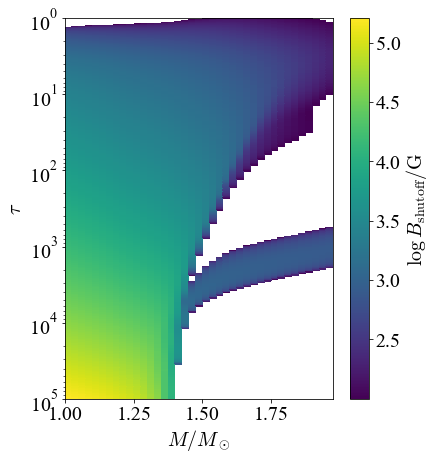

In [9]:
N = 1000
#r_grid = 1 - 10**np.linspace(-5,0,num=nR,endpoint=True)
tau_grid = 10**np.linspace(0,5,num=N,endpoint=True)

mS = []

B = []

for m,p in zip(*(mods,pf)):
	if m < 1.0 or m > 2.0:
		continue

	mS.append(m)

	tau = np.array(p.tau)

	B.append(np.interp(tau_grid, tau, p.B_shutoff))

B = np.array(B).T
B[B < 1e2] = 0

fig = plt.figure()
ax = plt.subplot(111)
cntr = plt.pcolormesh(mS, tau_grid, np.log10(B))
cbar = fig.colorbar(cntr, ax=ax)
cbar.ax.set_ylabel(r'$\log\, B_{\rm shutoff}/\mathrm{G}$')
plt.xlabel(r'$M/M_\odot$')
plt.ylabel(r'$\tau$')
plt.yscale('log')
plt.ylim([1e5,1])
plt.savefig('../figures/m_tau_2.png')


In [10]:
pickle.load(open('parsed.data','rb'))

['/Users/ajermyn/Dropbox/Active_Projects/LowMassMagnetic/output/runs/',
 '/Users/ajermyn/Dropbox/Active_Projects/LowMassMagnetic/output/runs/magnetic_low_mass_Z_MW_profiles_time_2022_03_08_14_44_28_sha_f557/runs/',
 [1.0,
  1.025,
  1.05,
  1.075,
  1.1,
  1.125,
  1.15,
  1.175,
  1.2,
  1.225,
  1.25,
  1.275,
  1.3,
  1.325,
  1.35,
  1.375,
  1.4,
  1.425,
  1.45,
  1.475,
  1.5,
  1.525,
  1.55,
  1.575,
  1.6,
  1.625,
  1.65,
  1.675,
  1.7,
  1.725,
  1.75,
  1.775,
  1.8,
  1.825,
  1.85,
  1.875,
  1.9,
  1.925,
  1.95,
  1.975],

All logB_shutoff_tau_3


<ipython-input-11-b18076428761>:106: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)


All logB_shutoff_tau_10


<ipython-input-11-b18076428761>:106: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)


All logB_shutoff_tau_100


<ipython-input-11-b18076428761>:106: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)


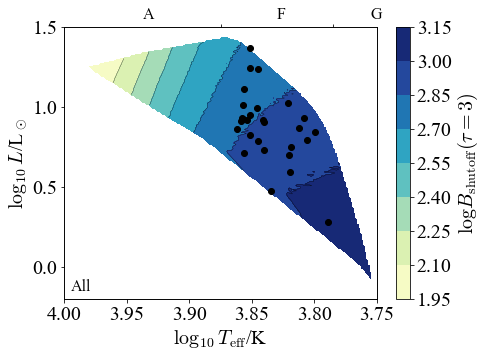

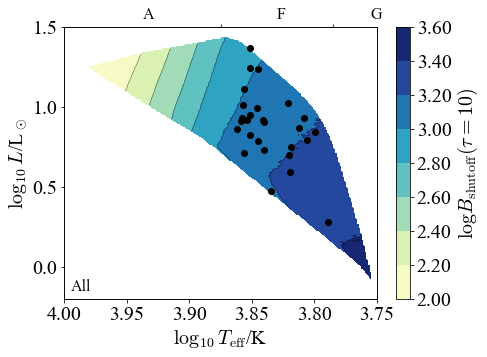

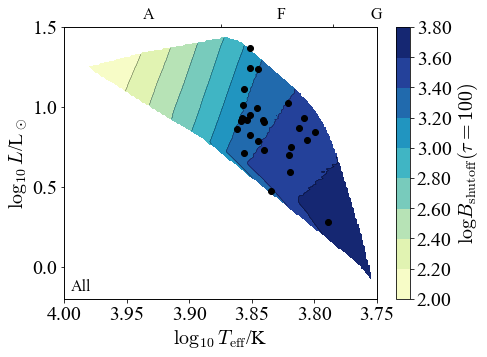

In [11]:
import mesa_reader as mr
import numpy as np
from pylab import *
from math import log10, pi
import pickle

from scipy import interpolate
from scipy.interpolate import griddata

from numpy import loadtxt
import pandas as pd 
 
from constants import *
from plot_settings import *
from functions import *
from getters import *
from star_data import stars

prefix,DIR,mods,hs,_ = pickle.load(open('parsed.data','rb'))

# Data Location
FIGURES='../figures/' # Place to save plots

# STRINGS
logteff=r'$\log_{10}\, T_{\rm eff}$/K'
logell=r'$\log_{10}\, L$/L$_\odot$'

# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def tri_area(xs,ys):
  arr = np.ones((3,3))
  arr[0] = xs
  arr[1] = ys
  area = 0.5 * np.linalg.det(arr)
  return area

def read_models(location,lis,hrd, CZ, getter, name, bar_label, xlim,ylim,dt,dl,cmap, extra_label):
    # Load the data
    x = []
    y = []
    z = []

    for i,j in enumerate(lis):
      h=hs[i]
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh = h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      x.append(logt[zams:])
      y.append(logl[zams:])
      z.append(getter(CZ,h)[zams:])

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    # Filter triangles by area and length to avoid high aspect ratio/super narrow ones/giant ones.
    triang = tri.Triangulation(x,y)
    areas = np.array(list(tri_area(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
    max_lengths = np.array(list(tri_max_length(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
    triang.set_mask((areas > 0.006) | (max_lengths > 0.8))

    # Interpolate onto a grid
    numcols, numrows = 200,200
    xi = np.linspace(min(xlim),max(xlim),numcols)
    yi = np.linspace(min(ylim),max(ylim),numcols)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    # Clip to 1st-99th percentile to avoid extremes at the edges.
    sel = np.isfinite(zi)
    maxval = np.percentile(zi[sel], 99)
    minval = np.percentile(zi[sel], 1)
    zi[zi > maxval] = maxval
    zi[zi < minval] = minval

    # Set up figure
    fig = plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    plt.gca().invert_xaxis()    

    # Use fewer contours when the data have a small range or that are noisy.
    # Everything is log-scales, so 1 is actually a characteristic scale here.
    levels = 8
    if maxval - minval < 1:
      levels = 4
    elif maxval - minval < 0.3:
      levels = 3
    elif name == 'logTurnover':
      levels = 6
    elif name == 'logSbot' or name == 'logStop':
      levels = 6

    # Plot contours
    ax.contour(xi, yi, zi, levels, colors='k', linewidths=0.3)    
    cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
    cbar = fig.colorbar(cntr1, ax=ax)
    cbar.ax.set_ylabel(bar_label)
    ls = list(cbar.ax.get_yticks())
    cbar.ax.set_yticklabels(['{:.2f}'.format(x) for x in ls])

 #   for j in hrd:
 #     h=mr.MesaData(DIR+str(j)+'/LOGS/history.data')
 #     model = h.model_number 
 #     logl = h.log_L
 #     logg = h.log_g 
 #     loglh=h.log_LH 
 #     center_h1 = h.center_h1 
 #     logt= h.log_Teff 
 #     zams=find_zams(logl,loglh,model)
 #     tams=find_tams(center_h1,model)
 #     zams=find_h(0.001,center_h1,model)
 #     ell = (10**logt)**4.0/(10**logg)
 #     ell=np.log10(ell/ell_sun)  
 #     ax.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
 #     ax.text(logt[zams]+dt,logl[zams]+dl,str(j)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
                

    # Plot stars
    ax.scatter(stars[:,0], stars[:,1], c='k')

    # Format plot
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)

    ax.text(max(xlim)-0.02*(max(xlim)-min(xlim)),min(ylim)+0.03*(max(ylim)-min(ylim)),CZ,ha='left',fontsize=16)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)   

    ax2 = ax.twiny()

    # Bounds of spectral types
    tick_locs = np.log10((1e5,3e4,1e4,7500,6100,5300,3800,2650))
    tick_labels = list('' for _ in tick_locs)

    ind_first = 0
    for i in range(len(tick_locs)):
      if tick_locs[i] < max(xlim):
        ind_first = i
        break

    ind_last = len(tick_locs)
    for i in range(len(tick_locs)-1,0,-1):
      if tick_locs[i] > min(xlim):
        ind_last = i+1
        break

    ax2.set_xticks(tick_locs[ind_first:ind_last])
    ax2.set_xticklabels(tick_labels[ind_first:ind_last])

    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim) # This has to come later, otherwise matplotlib expands the xlims to accomoddate the new ticks.

    # Spectral type labels
    locs = 0.5 * (tick_locs[1:] + tick_locs[:-1])
    labels = ('O','B','A','F','G','K','M')
    for loc,lab in zip(*(locs,labels)):
      if loc > min(xlim) and loc < max(xlim):
        ax.text(loc,max(ylim)+0.03*(max(ylim)-min(ylim)),lab)

    plt.savefig(FIGURES+CZ+'_'+name+'.pdf',bbox_inches='tight')

# Plot the CZ-dependent quantities

CZs = [
  ('Envelope',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03),
  ('HI',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03),
  ('HeII',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03)
]

#plots = [
#  (logBshutoff, 'logBshutoff', r'$\log B_{\rm shutoff}$','YlOrRd')
#]

#for getter,name,label,cmap in plots:
#  for CZ,xlim,ylim,hrd,dt,dl in CZs:
#    print(CZ,name)
#    read_models(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)

# Now plot the one-off's

CZs = [
  ('All',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03)
]

plots = [
  (logB_shutoff_tau_3, 'logB_shutoff_tau_3', r'$\log B_{\rm shutoff}(\tau=3)$','YlGnBu'),
  (logB_shutoff_tau_10, 'logB_shutoff_tau_10', r'$\log B_{\rm shutoff}(\tau=10)$','YlGnBu'),
  (logB_shutoff_tau_100, 'logB_shutoff_tau_100', r'$\log B_{\rm shutoff}(\tau=100)$','YlGnBu')
]



for getter,name,label,cmap in plots:
  for CZ,xlim,ylim,hrd,dt,dl in CZs:
    print(CZ,name)
    read_models(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)



In [12]:
# LOAD THE STAR DATA
import pandas as pd
DIR = '../data/'
file1='paper1_targets_29mar23.csv'

df1 = pd.read_csv(DIR+file1, 
                 sep=",", 
                 skiprows=1, 
                 skipfooter = 0,
                 usecols=[0,1,2,3], 
                 names=['HD','TIC','T','L'])
print (df1)

T=df1['T']
L=df1['L']
HD = df1['HD']

T = [float(item) for item in T]
L = [float(item) for item in L]

LogT = np.log10(T)
LogL = np.log10(L)

           HD            TIC     T        L
0   HD 113414    TIC 1727745  6150   1.8730
1    HD 97127   TIC 77128654  6300   6.9449
2    HD101065  TIC 163587609  6400   5.9389
3   HD 216641  TIC 152808505  6430   8.3600
4   HD 176384  TIC 380651050  6490   7.3296
..        ...            ...   ...      ...
57   HD 63773   TIC 17676722  8320  14.4610
58   HD 43226   TIC 41259805  8360  11.9514
59   HD 3748A    TIC 3814749  8420   5.4278
60  V* AP Scl  TIC 326185137  8500  15.5983
61   HD 45698  TIC 119327278  8540  13.0858

[62 rows x 4 columns]


All logB_shutoff_tau_3


<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 3.0733231906399503
HD 97127 0.8416659966883413 3.7993405494535817 2.9371273705300807
HD101065 0.7737060126294676 3.806179973983887 2.9465896373979987
HD 216641 0.9222062774390164 3.808210972924222 2.9048263194896293
HD 176384 0.8650802744320084 3.812244696800369 2.910899463279595
HD 107619 0.7338069364288412 3.8188854145940097 2.935150229821814
HD 258048 0.5759033790343544 3.8195439355418688 2.9751656070417916
HD 213637 0.7067177823367587 3.82020145948564 2.9338085570874526
HD 151860 0.983815657755331 3.821513528404773 2.8738459129511575
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 2.925660708787049
HD 217522 0.8715495857524967 3.840106094456758 2.8697436397008698
HD 154708 0.7203991331728834 3.840106094456758 2.9054600025675583
HD 119027 0.9263887551795927 3.841359470454855 2.860553223803537
HD 69013 0.9057527185230801 3.8457180179666586 2.849053937740347
HD 51203 0.9279705681273523 3.85125834

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 3.3511607151438625
HD 97127 0.8416659966883413 3.7993405494535817 3.212092582399002
HD101065 0.7737060126294676 3.806179973983887 3.2113356417341787
HD 216641 0.9222062774390164 3.808210972924222 3.174249676466104
HD 176384 0.8650802744320084 3.812244696800369 3.1866796956583574
HD 107619 0.7338069364288412 3.8188854145940097 3.19569227075624
HD 258048 0.5759033790343544 3.8195439355418688 3.23447157098828
HD 213637 0.7067177823367587 3.82020145948564 3.200268683656435
HD 151860 0.983815657755331 3.821513528404773 3.1349099202246506
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.1552680059409113
HD 217522 0.8715495857524967 3.840106094456758 3.118836254947084
HD 154708 0.7203991331728834 3.840106094456758 3.1466527913391396
HD 119027 0.9263887551795927 3.841359470454855 3.094614550876976
HD 69013 0.9057527185230801 3.8457180179666586 3.0903156531668508
HD 51203 0.9279705681273523 3.851258348719

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 3.6947787539475296
HD 97127 0.8416659966883413 3.7993405494535817 3.5132268128572246
HD101065 0.7737060126294676 3.806179973983887 3.5161446046399405
HD 216641 0.9222062774390164 3.808210972924222 3.4762549526061477
HD 176384 0.8650802744320084 3.812244696800369 3.4770845185786996
HD 107619 0.7338069364288412 3.8188854145940097 3.4924958069195533
HD 258048 0.5759033790343544 3.8195439355418688 3.538134982316387
HD 213637 0.7067177823367587 3.82020145948564 3.4955082692532926
HD 151860 0.983815657755331 3.821513528404773 3.415102314907694
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.3324200732233464
HD 217522 0.8715495857524967 3.840106094456758 3.379787016932571
HD 154708 0.7203991331728834 3.840106094456758 3.425065827214608
HD 119027 0.9263887551795927 3.841359470454855 3.3512393422869504
HD 69013 0.9057527185230801 3.8457180179666586 3.327583793534558
HD 51203 0.9279705681273523 3.85125834

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 4.070074686150418
HD 97127 0.8416659966883413 3.7993405494535817 3.850748510329618
HD101065 0.7737060126294676 3.806179973983887 3.853326475509018
HD 216641 0.9222062774390164 3.808210972924222 3.795171522479823
HD 176384 0.8650802744320084 3.812244696800369 3.7961183875982023
HD 107619 0.7338069364288412 3.8188854145940097 3.8189972163535195
HD 258048 0.5759033790343544 3.8195439355418688 3.8885597274791106
HD 213637 0.7067177823367587 3.82020145948564 3.825032825181296
HD 151860 0.983815657755331 3.821513528404773 3.674418517752919
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.504324407795025
HD 217522 0.8715495857524967 3.840106094456758 3.5102551192186553
HD 154708 0.7203991331728834 3.840106094456758 3.6406667667435357
HD 119027 0.9263887551795927 3.841359470454855 3.4506290437454012
HD 69013 0.9057527185230801 3.8457180179666586 3.4046914537878763
HD 51203 0.9279705681273523 3.8512583487

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 4.551349388187342
HD 97127 0.8416659966883413 3.7993405494535817 4.245168572606872
HD101065 0.7737060126294676 3.806179973983887 4.210011686955376
HD 216641 0.9222062774390164 3.808210972924222 4.057580895046797
HD 176384 0.8650802744320084 3.812244696800369 4.053021869400624
HD 107619 0.7338069364288412 3.8188854145940097 4.039465214491827
HD 258048 0.5759033790343544 3.8195439355418688 4.266532067571298
HD 213637 0.7067177823367587 3.82020145948564 4.0762227166487435
HD 151860 0.983815657755331 3.821513528404773 3.709974832706294
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.742441431736623
HD 217522 0.8715495857524967 3.840106094456758 3.5102551192186553
HD 154708 0.7203991331728834 3.840106094456758 3.649480353467453
HD 119027 0.9263887551795927 3.841359470454855 3.4508392106009964
HD 69013 0.9057527185230801 3.8457180179666586 3.4046914537878763
HD 51203 0.9279705681273523 3.8512583487190

/Users/mcantiello/Dropbox (Personal)/work/gwade/code/getters.py:28: RuntimeWarning: divide by zero encountered in log10
  return log10(C)
<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 6.822300872108144
HD 97127 0.8416659966883413 3.7993405494535817 4.8174539716853815
HD101065 0.7737060126294676 3.806179973983887 4.67110403421006
HD 216641 0.9222062774390164 3.808210972924222 4.0859428642832825
HD 176384 0.8650802744320084 3.812244696800369 4.151180056273205
HD 107619 0.7338069364288412 3.8188854145940097 4.207657911947479
HD 258048 0.5759033790343544 3.8195439355418688 4.635618954129399
HD 213637 0.7067177823367587 3.82020145948564 4.14665660164296
HD 151860 0.983815657755331 3.821513528404773 3.709974832706294
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 5.014774545762947
HD 217522 0.8715495857524967 3.840106094456758 3.5102551192186553
HD 154708 0.7203991331728834 3.840106094456758 3.649480353467453
HD 119027 0.9263887551795927 3.841359470454855 3.4508392106009964
HD 69013 0.9057527185230801 3.8457180179666586 3.4046914537878763
HD 51203 0.9279705681273523 3.85125834871907

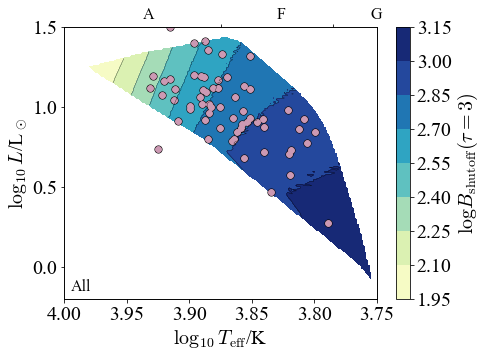

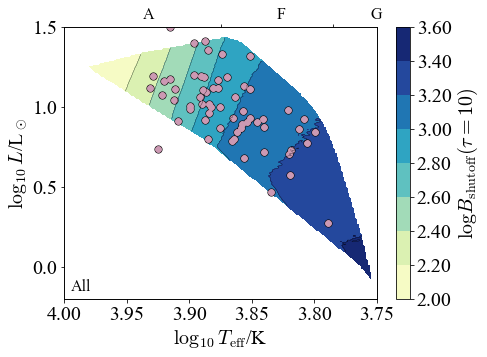

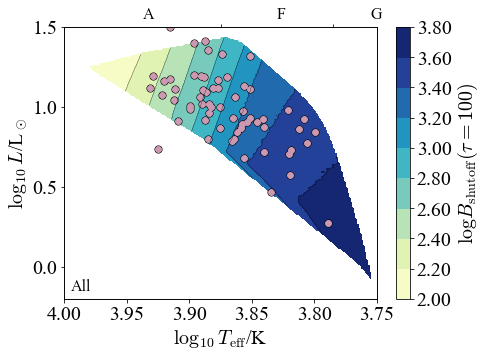

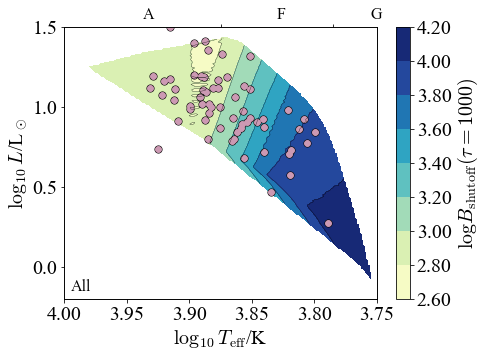

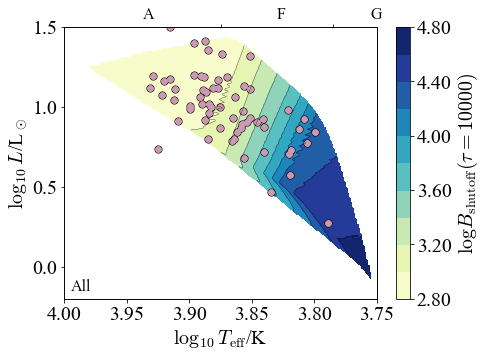

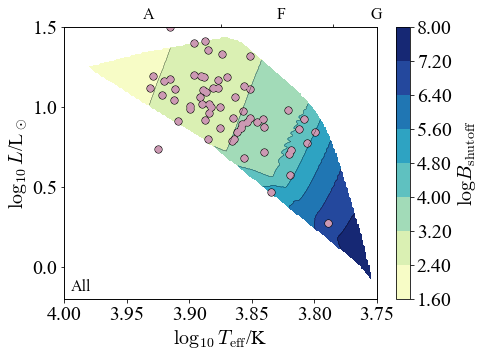

In [13]:
import mesa_reader as mr
import numpy as np
from pylab import *
from math import log10, pi
import pickle

from scipy import interpolate
from scipy.interpolate import griddata

from numpy import loadtxt
import pandas as pd 
 
from constants import *
from plot_settings import *
from functions import *
from getters import *
from star_data import stars

# Define some colors
BLACK      = (0.00,0.00,0.00)
ORANGE     = (0.90,0.60,0.00)
SKY_BLUE   = (0.35,0.70,0.90)
BLUE_GREEN = (0.00,0.60,0.50)
YELLOW     = (0.95,0.90,0.25)
BLUE       = (0.00,0.45,0.70)
VERMILLION = (0.80,0.40,0.00)
RED_PURPLE = (0.80,0.60,0.70)

prefix,DIR,mods,hs,_ = pickle.load(open('parsed.data','rb'))

# Data Location
FIGURES='../figures/' # Place to save plots

# STRINGS
logteff=r'$\log_{10}\, T_{\rm eff}$/K'
logell=r'$\log_{10}\, L$/L$_\odot$'

# Use ell_sun to make Spectroscopic HRD, if needed
ell_sun=(5777)**4.0/(274*100)  

def tri_area(xs,ys):
  arr = np.ones((3,3))
  arr[0] = xs
  arr[1] = ys
  area = 0.5 * np.linalg.det(arr)
  return area

def read_models(location,lis,hrd, CZ, getter, name, bar_label, xlim,ylim,dt,dl,cmap, extra_label):
    # Load the data
    x = []
    y = []
    z = []

    for i,j in enumerate(lis):
      h=hs[i]
      model = h.model_number 
      logl = h.log_L
      logg = h.log_g 
      loglh = h.log_LH 
      center_h1 = h.center_h1 
      logt= h.log_Teff 
    
      zams=find_zams(logl,loglh,model)
      tams=find_tams(center_h1,model)
      zams=find_h(0.001,center_h1,model)
        
      # Create Lists  
      x.append(logt[zams:])
      y.append(logl[zams:])
      z.append(getter(CZ,h)[zams:])

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    # Filter triangles by area and length to avoid high aspect ratio/super narrow ones/giant ones.
    triang = tri.Triangulation(x,y)
    areas = np.array(list(tri_area(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
    max_lengths = np.array(list(tri_max_length(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
    triang.set_mask((areas > 0.006) | (max_lengths > 0.8))

    # Interpolate onto a grid
    numcols, numrows = 200,200
    xi = np.linspace(min(xlim),max(xlim),numcols)
    yi = np.linspace(min(ylim),max(ylim),numcols)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    
    # Iterpolate star data
    
    bcrit_stars = interpolator(LogT,LogL)
    i = 0
    #print(len(bcrit_stars))
    print('HD[i],LogL[i],LogT[i],bcrit_stars[i]')
    for i in range(0,len(bcrit_stars)-1):
        print(HD[i],LogL[i],LogT[i],bcrit_stars[i])
    
    # Clip to 1st-99th percentile to avoid extremes at the edges.
    sel = np.isfinite(zi)
    maxval = np.percentile(zi[sel], 99)
    minval = np.percentile(zi[sel], 1)
    zi[zi > maxval] = maxval
    zi[zi < minval] = minval

    # Set up figure
    fig = plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    plt.gca().invert_xaxis()    

    # Use fewer contours when the data have a small range or that are noisy.
    # Everything is log-scales, so 1 is actually a characteristic scale here.
    levels = 8
    if maxval - minval < 1:
      levels = 4
    elif maxval - minval < 0.3:
      levels = 3
    elif name == 'logTurnover':
      levels = 6
    elif name == 'logSbot' or name == 'logStop':
      levels = 6

    # Plot contours
    ax.contour(xi, yi, zi, levels, colors='k', linewidths=0.3)    
    cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
    cbar = fig.colorbar(cntr1, ax=ax)
    cbar.ax.set_ylabel(bar_label)
    ls = list(cbar.ax.get_yticks())
    cbar.ax.set_yticklabels(['{:.2f}'.format(x) for x in ls])

 #   for j in hrd:
 #     h=mr.MesaData(DIR+str(j)+'/LOGS/history.data')
 #     model = h.model_number 
 #     logl = h.log_L
 #     logg = h.log_g 
 #     loglh=h.log_LH 
 #     center_h1 = h.center_h1 
 #     logt= h.log_Teff 
 #     zams=find_zams(logl,loglh,model)
 #     tams=find_tams(center_h1,model)
 #     zams=find_h(0.001,center_h1,model)
 #     ell = (10**logt)**4.0/(10**logg)
 #     ell=np.log10(ell/ell_sun)  
 #     ax.plot(logt[zams:],logl[zams:],c='gray',alpha=1.0)
 #     ax.text(logt[zams]+dt,logl[zams]+dl,str(j)+r'$M_\odot$',ha='center',fontsize=14) # ,verticalalignment='center',rotation='vertical',  
                

    # Plot stars
    #ax.scatter(stars[:,0], stars[:,1], c='k')
    ax.scatter(LogT, LogL, c=BLACK, s= 50)
    ax.scatter(LogT, LogL, c=RED_PURPLE, s= 35)

    # Format plot
    ax.set_xlabel(logteff)
    ax.set_ylabel(logell)

    ax.text(max(xlim)-0.02*(max(xlim)-min(xlim)),min(ylim)+0.03*(max(ylim)-min(ylim)),CZ,ha='left',fontsize=16)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)   

    ax2 = ax.twiny()

    # Bounds of spectral types
    tick_locs = np.log10((1e5,3e4,1e4,7500,6100,5300,3800,2650))
    tick_labels = list('' for _ in tick_locs)

    ind_first = 0
    for i in range(len(tick_locs)):
      if tick_locs[i] < max(xlim):
        ind_first = i
        break

    ind_last = len(tick_locs)
    for i in range(len(tick_locs)-1,0,-1):
      if tick_locs[i] > min(xlim):
        ind_last = i+1
        break

    ax2.set_xticks(tick_locs[ind_first:ind_last])
    ax2.set_xticklabels(tick_labels[ind_first:ind_last])

    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim) # This has to come later, otherwise matplotlib expands the xlims to accomoddate the new ticks.

    # Spectral type labels
    locs = 0.5 * (tick_locs[1:] + tick_locs[:-1])
    labels = ('O','B','A','F','G','K','M')
    for loc,lab in zip(*(locs,labels)):
      if loc > min(xlim) and loc < max(xlim):
        ax.text(loc,max(ylim)+0.03*(max(ylim)-min(ylim)),lab)

    plt.savefig(FIGURES+CZ+'_'+name+'.pdf',bbox_inches='tight')

# Plot the CZ-dependent quantities

CZs = [
  ('Envelope',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03),
  ('HI',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03),
  ('HeII',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03)
]

#plots = [
#  (logBshutoff, 'logBshutoff', r'$\log B_{\rm shutoff}$','YlOrRd')
#]

#for getter,name,label,cmap in plots:
#  for CZ,xlim,ylim,hrd,dt,dl in CZs:
#    print(CZ,name)
#    read_models(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)



# Now plot the one-off's

CZs = [
  ('All',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03)
]

plots = [
  (logB_shutoff_tau_3, 'logB_shutoff_tau_3', r'$\log B_{\rm shutoff}(\tau=3)$','YlGnBu'),
  (logB_shutoff_tau_10, 'logB_shutoff_tau_10', r'$\log B_{\rm shutoff}(\tau=10)$','YlGnBu'),
  (logB_shutoff_tau_100, 'logB_shutoff_tau_100', r'$\log B_{\rm shutoff}(\tau=100)$','YlGnBu'),
    (logB_shutoff_tau_1000, 'logB_shutoff_tau_1000', r'$\log B_{\rm shutoff}(\tau=1000)$','YlGnBu'),
    (logB_shutoff_tau_1d4, 'logB_shutoff_tau_10000', r'$\log B_{\rm shutoff}(\tau=10000)$','YlGnBu'),
    (logB_shutoff_envelope, 'logB_shutoff_envelope', r'$\log B_{\rm shutoff}$','YlGnBu')
]



for getter,name,label,cmap in plots:
  for CZ,xlim,ylim,hrd,dt,dl in CZs:
    print(CZ,name)
    read_models(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)



In [14]:
#read_models(location,lis,hrd, CZ, getter, name, bar_label, xlim,ylim,dt,dl,cmap, extra_label):
#(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)

location = DIR
lis = mods
bar_label = label 
extra_label = None 

# Load the data
x = []
y = []
z = []

for i,j in enumerate(lis):
  h=hs[i]
  model = h.model_number 
  logl = h.log_L
  logg = h.log_g 
  loglh = h.log_LH 
  center_h1 = h.center_h1 
  logt= h.log_Teff 

  zams=find_zams(logl,loglh,model)
  tams=find_tams(center_h1,model)
  zams=find_h(0.001,center_h1,model)

  # Create Lists  
  x.append(logt[zams:])
  y.append(logl[zams:])
  z.append(getter(CZ,h)[zams:])

x=array(list(flatten(x)))
y=array(list(flatten(y)))
z=array(list(flatten(z)))

# Filter triangles by area and length to avoid high aspect ratio/super narrow ones/giant ones.
triang = tri.Triangulation(x,y)
areas = np.array(list(tri_area(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
max_lengths = np.array(list(tri_max_length(x[triang.triangles[q]], y[triang.triangles[q]]) for q in range(len(triang.triangles))))
triang.set_mask((areas > 0.006) | (max_lengths > 0.8))

# Interpolate onto a grid
numcols, numrows = 200,200
xi = np.linspace(min(xlim),max(xlim),numcols)
yi = np.linspace(min(ylim),max(ylim),numcols)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)


# Iterpolate star data
# LogT,LogL -> Bcrit
print(interpolator(3.9,1.1))
#print(interpolator(3.973,2.113))
    
    

   


/Users/mcantiello/Dropbox (Personal)/work/gwade/code/getters.py:28: RuntimeWarning: divide by zero encountered in log10
  return log10(C)


2.6661748793138926


In [15]:
prefix,DIR,mods,hs,pf = pickle.load(open('parsed.data','rb'))
hh=hs[15]
hh.bulk_names
hh.file_name
hh.star_mass[0]

1.375

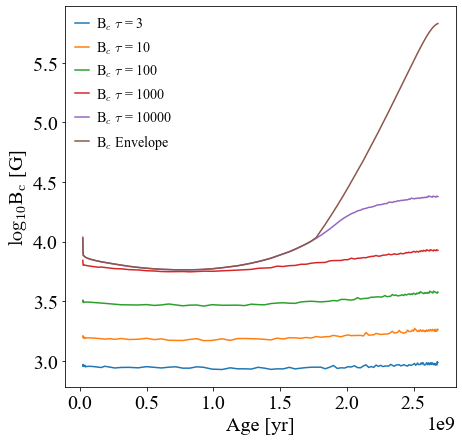

In [16]:

model = hh.model_number 
logl = hh.log_L
logg = hh.log_g 
loglh = hh.log_LH 
center_h1 = hh.center_h1 
logt= hh.log_Teff 
    
zams=find_zams(logl,loglh,model)
tams=find_tams(center_h1,model)
zams=find_h(0.001,center_h1,model)


A = hh.Envelope_B_shutoff
B = hh.HI_B_shutoff   
s = len(A)    
C = [(A[i] if A[i] > 0 else 0) + (B[i] if B[i] > 0 else 0) for i in range(s)]

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
    
ax.plot(hh.star_age[zams:tams],np.log10(hh.B_shutoff_down_to_tau_3[zams:tams]),label=r'B$_c$ $\tau$ = 3')
ax.plot(hh.star_age[zams:tams],np.log10(hh.B_shutoff_down_to_tau_10[zams:tams]),label=r'B$_c$ $\tau$ = 10')
ax.plot(hh.star_age[zams:tams],np.log10(hh.B_shutoff_down_to_tau_100[zams:tams]),label=r'B$_c$ $\tau$ = 100')
ax.plot(hh.star_age[zams:tams],np.log10(hh.B_shutoff_down_to_tau_1000[zams:tams]),label=r'B$_c$ $\tau$ = 1000')
ax.plot(hh.star_age[zams:tams],np.log10(hh.B_shutoff_down_to_tau_1d4[zams:tams]),label=r'B$_c$ $\tau$ = 10000')
#ax.plot(hh.star_age[zams:tams],np.log10(hh.Envelope_B_shutoff[zams:tams]))
#ax.plot(hh.star_age[zams:tams],np.log10(hh.HI_B_shutoff[zams:tams]))
ax.plot(hh.star_age[zams:tams],np.log10(C[zams:tams]),label=r'B$_c$ Envelope')
ax.legend()
ax.set_xlabel('Age [yr]')
ax.set_ylabel(r'$\log_{10}$B$_{\rm c}$ [G]')
name='Bcrits'
mass=str(hh.star_mass[0])
plt.savefig(FIGURES+name+'_'+mass+'.pdf',bbox_inches='tight')


All logB_shutoff_tau_3


<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 3.0733231906399503
HD 97127 0.8416659966883413 3.7993405494535817 2.9371273705300807
HD101065 0.7737060126294676 3.806179973983887 2.9465896373979987
HD 216641 0.9222062774390164 3.808210972924222 2.9048263194896293
HD 176384 0.8650802744320084 3.812244696800369 2.910899463279595
HD 107619 0.7338069364288412 3.8188854145940097 2.935150229821814
HD 258048 0.5759033790343544 3.8195439355418688 2.9751656070417916
HD 213637 0.7067177823367587 3.82020145948564 2.9338085570874526
HD 151860 0.983815657755331 3.821513528404773 2.8738459129511575
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 2.925660708787049
HD 217522 0.8715495857524967 3.840106094456758 2.8697436397008698
HD 154708 0.7203991331728834 3.840106094456758 2.9054600025675583
HD 119027 0.9263887551795927 3.841359470454855 2.860553223803537
HD 69013 0.9057527185230801 3.8457180179666586 2.849053937740347
HD 51203 0.9279705681273523 3.85125834

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 3.3511607151438625
HD 97127 0.8416659966883413 3.7993405494535817 3.212092582399002
HD101065 0.7737060126294676 3.806179973983887 3.2113356417341787
HD 216641 0.9222062774390164 3.808210972924222 3.174249676466104
HD 176384 0.8650802744320084 3.812244696800369 3.1866796956583574
HD 107619 0.7338069364288412 3.8188854145940097 3.19569227075624
HD 258048 0.5759033790343544 3.8195439355418688 3.23447157098828
HD 213637 0.7067177823367587 3.82020145948564 3.200268683656435
HD 151860 0.983815657755331 3.821513528404773 3.1349099202246506
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.1552680059409113
HD 217522 0.8715495857524967 3.840106094456758 3.118836254947084
HD 154708 0.7203991331728834 3.840106094456758 3.1466527913391396
HD 119027 0.9263887551795927 3.841359470454855 3.094614550876976
HD 69013 0.9057527185230801 3.8457180179666586 3.0903156531668508
HD 51203 0.9279705681273523 3.851258348719

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 3.6947787539475296
HD 97127 0.8416659966883413 3.7993405494535817 3.5132268128572246
HD101065 0.7737060126294676 3.806179973983887 3.5161446046399405
HD 216641 0.9222062774390164 3.808210972924222 3.4762549526061477
HD 176384 0.8650802744320084 3.812244696800369 3.4770845185786996
HD 107619 0.7338069364288412 3.8188854145940097 3.4924958069195533
HD 258048 0.5759033790343544 3.8195439355418688 3.538134982316387
HD 213637 0.7067177823367587 3.82020145948564 3.4955082692532926
HD 151860 0.983815657755331 3.821513528404773 3.415102314907694
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.3324200732233464
HD 217522 0.8715495857524967 3.840106094456758 3.379787016932571
HD 154708 0.7203991331728834 3.840106094456758 3.425065827214608
HD 119027 0.9263887551795927 3.841359470454855 3.3512393422869504
HD 69013 0.9057527185230801 3.8457180179666586 3.327583793534558
HD 51203 0.9279705681273523 3.85125834

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 4.070074686150418
HD 97127 0.8416659966883413 3.7993405494535817 3.850748510329618
HD101065 0.7737060126294676 3.806179973983887 3.853326475509018
HD 216641 0.9222062774390164 3.808210972924222 3.795171522479823
HD 176384 0.8650802744320084 3.812244696800369 3.7961183875982023
HD 107619 0.7338069364288412 3.8188854145940097 3.8189972163535195
HD 258048 0.5759033790343544 3.8195439355418688 3.8885597274791106
HD 213637 0.7067177823367587 3.82020145948564 3.825032825181296
HD 151860 0.983815657755331 3.821513528404773 3.674418517752919
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.504324407795025
HD 217522 0.8715495857524967 3.840106094456758 3.5102551192186553
HD 154708 0.7203991331728834 3.840106094456758 3.6406667667435357
HD 119027 0.9263887551795927 3.841359470454855 3.4506290437454012
HD 69013 0.9057527185230801 3.8457180179666586 3.4046914537878763
HD 51203 0.9279705681273523 3.8512583487

<ipython-input-13-41e44d9ad758>:126: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(xi, yi, zi, levels, cmap=cmap, linewidths=0.3)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HD[i],LogL[i],LogT[i],bcrit_stars[i]
HD 113414 0.2725377773752374 3.788875115775417 4.551349388187342
HD 97127 0.8416659966883413 3.7993405494535817 4.245168572606872
HD101065 0.7737060126294676 3.806179973983887 4.210011686955376
HD 216641 0.9222062774390164 3.808210972924222 4.057580895046797
HD 176384 0.8650802744320084 3.812244696800369 4.053021869400624
HD 107619 0.7338069364288412 3.8188854145940097 4.039465214491827
HD 258048 0.5759033790343544 3.8195439355418688 4.266532067571298
HD 213637 0.7067177823367587 3.82020145948564 4.0762227166487435
HD 151860 0.983815657755331 3.821513528404773 3.709974832706294
TYC 9087-1516-1 0.4694096085167549 3.8344207036815328 3.742441431736623
HD 217522 0.8715495857524967 3.840106094456758 3.5102551192186553
HD 154708 0.7203991331728834 3.840106094456758 3.649480353467453
HD 119027 0.9263887551795927 3.841359470454855 3.4508392106009964
HD 69013 0.9057527185230801 3.8457180179666586 3.4046914537878763
HD 51203 0.9279705681273523 3.8512583487190

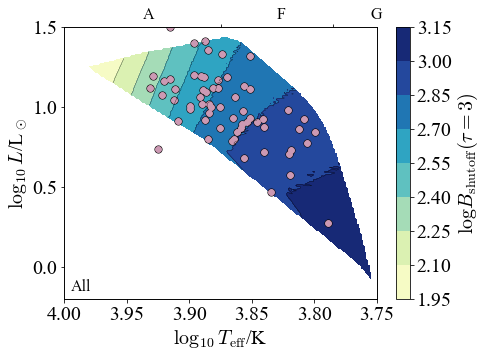

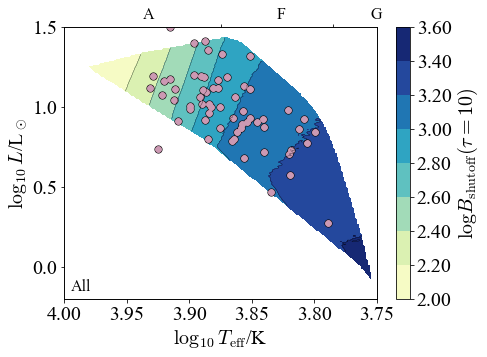

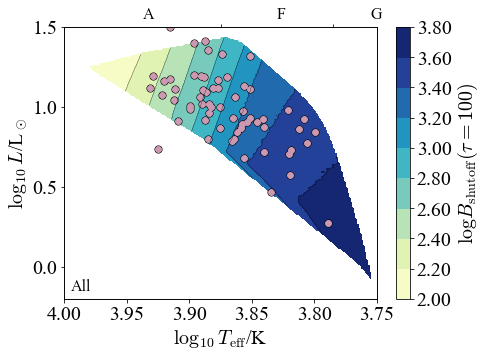

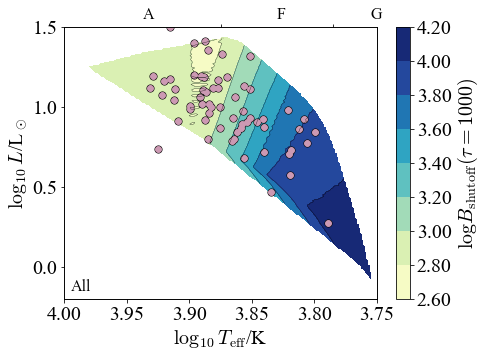

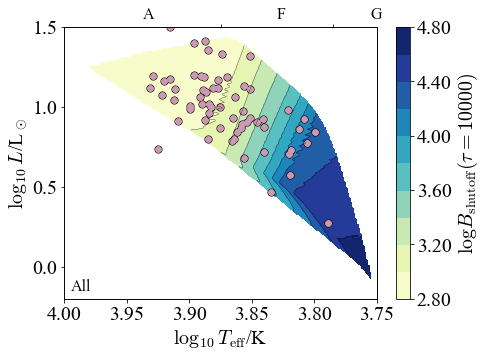

In [17]:

CZs = [
  ('All',[4.0,3.75],[-0.2,1.5],[1.1,1.2,1.4,1.6,1.7],0.04,-0.03)
]

plots = [
  (logB_shutoff_tau_3, 'logB_shutoff_tau_3', r'$\log B_{\rm shutoff}(\tau=3)$','YlGnBu'),
  (logB_shutoff_tau_10, 'logB_shutoff_tau_10', r'$\log B_{\rm shutoff}(\tau=10)$','YlGnBu'),
  (logB_shutoff_tau_100, 'logB_shutoff_tau_100', r'$\log B_{\rm shutoff}(\tau=100)$','YlGnBu'),
   (logB_shutoff_tau_1000, 'logB_shutoff_tau_1000', r'$\log B_{\rm shutoff}(\tau=1000)$','YlGnBu'),
    (logB_shutoff_tau_1d4, 'logB_shutoff_tau_10000', r'$\log B_{\rm shutoff}(\tau=10000)$','YlGnBu')
]


for getter,name,label,cmap in plots:
  for CZ,xlim,ylim,hrd,dt,dl in CZs:
    print(CZ,name)
    read_models(DIR,mods,hrd,CZ,getter,name,label,xlim,ylim,dt,dl,cmap,None)

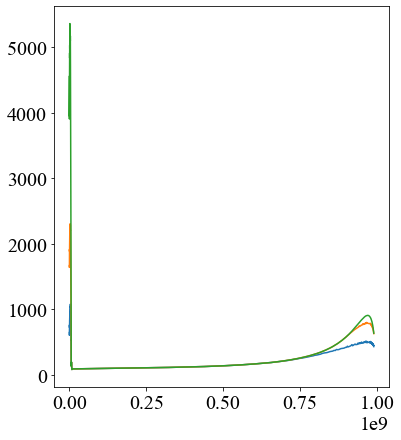

In [18]:
plt.plot(h.star_age,h.B_shutoff_down_to_tau_3)
plt.plot(h.star_age,h.B_shutoff_down_to_tau_10)
plt.plot(h.star_age,h.B_shutoff_down_to_tau_100)

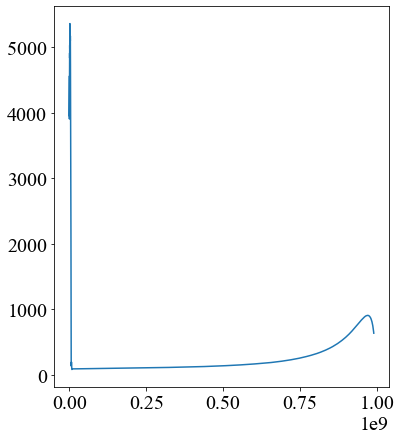

In [19]:
plt.plot(h.star_age,h.B_shutoff_down_to_tau_100)

In [20]:
p=mr.MesaData('../inlists/template/profile_mid_MS.data')

In [21]:
p.bulk_names

('zone',
 'mass',
 'q',
 'logdq',
 'log_q',
 'temperature',
 'logRho',
 'entropy',
 'pressure',
 'opacity',
 'radius',
 'velocity',
 'luminosity',
 'eps_nuc',
 'net_nuclear_energy',
 'eps_grav',
 'ye',
 'mixing_type',
 'mlt_mixing_length',
 'mlt_mixing_type',
 'pressure_scale_height',
 'lum_conv_div_lum_rad',
 'lum_conv_div_L',
 'tau',
 'logtau',
 'grada',
 'gamma1',
 'log_opacity',
 'super_ad',
 'log_D_mix',
 'log_conv_vel',
 'conv_vel_div_csound',
 'log_mlt_D_mix',
 'gradr',
 'h1',
 'he3',
 'he4',
 'c12',
 'n14',
 'o16',
 'ne20',
 'mg24',
 'pp',
 'cno',
 'tri_alfa',
 'burn_c',
 'burn_n',
 'burn_o',
 'burn_ne',
 'burn_na',
 'burn_mg',
 'burn_si',
 'burn_s',
 'burn_ar',
 'burn_ca',
 'burn_ti',
 'burn_cr',
 'burn_fe',
 'c12_c12',
 'c12_o16',
 'o16_o16',
 'pnhe4',
 'photo',
 'ni56_co56',
 'co56_fe56',
 'other',
 'brunt_N2',
 'brunt_N',
 'log_f_div_rhocs3',
 'log_fconv_div_rhocs3',
 'log_Fedd_div_rhocs3',
 'B_shutoff')

<ipython-input-22-e22c93a635f4>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(p.temperature),np.log10(p.B_shutoff))


(0.0, 20.0)

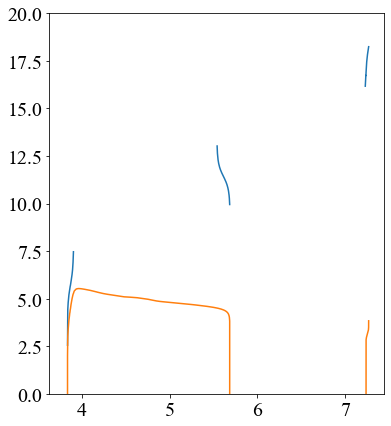

In [22]:
plt.plot(np.log10(p.temperature),np.log10(p.B_shutoff))
plt.plot(np.log10(p.temperature),p.log_conv_vel)

plt.ylim(0,20)

<ipython-input-23-4a8abb1967c9>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(p.logtau,np.log10(p.B_shutoff))


(0.0, 10.0)

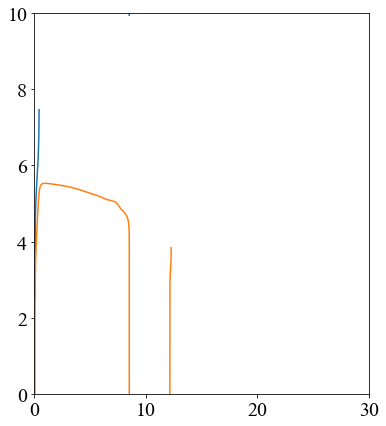

In [23]:
plt.plot(p.logtau,np.log10(p.B_shutoff))
plt.plot(p.logtau,p.log_conv_vel)

plt.xlim(0,30)
plt.ylim(0,10)